In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import langdetect
from scipy.stats import sem

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\holger.doerner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\holger.doerner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
df = pd.read_csv('lyrics.csv')

                index    song    year  artist  lyrics
genre                                                
Country         17286   17286   17286   17286   14387
Electronic      16205   16205   16205   16205    7966
Folk             3241    3241    3241    3241    2243
Hip-Hop         33965   33965   33965   33965   24850
Indie            5732    5732    5732    5732    3149
Jazz            17147   17145   17147   17147    7971
Metal           28408   28408   28408   28408   23759
Not Available   29814   29814   29814   29814   23941
Other           23683   23683   23683   23683    5189
Pop             49444   49444   49444   49444   40466
R&B              5935    5935    5935    5935    3401
Rock           131377  131377  131377  131377  109235


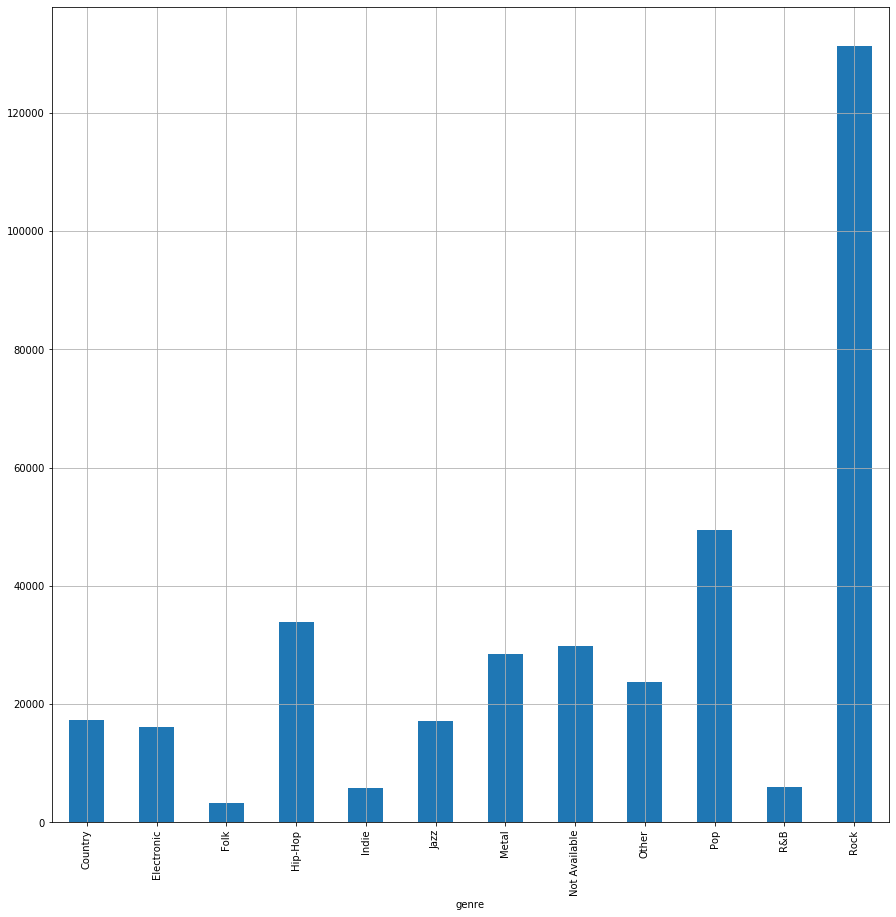

In [494]:
df.groupby('genre')['genre'].count().plot(kind='bar', grid=True, figsize=(15,15))
print(df.groupby('genre').count())

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
import re

class column_selector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]
    

class genre_selector(BaseEstimator, TransformerMixin):
    def __init__(self, genres):
        self.genres = genres
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X[X['genre'].isin(self.genres)]
        return X
    
    
class remove_na(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if type(self.columns) is list:
            for column in self.columns:
                X = X[X[column].notnull()]
        else:
            X = X[X[self.columns].notnull()]
        return X
    
    
class clean_lyrics(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        stemmer = WordNetLemmatizer()
        # remove all special chars, symbols and numbers
        X['lyrics'] = X['lyrics'].replace(r'[^A-Za-z]', ' ', regex=True)
        # remove all single characters surrounded by whitepace
        X['lyrics'] = X['lyrics'].replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)
        # remove single characters at beginning of text
        X['lyrics'] = X['lyrics'].replace(r'\^[a-zA-Z]\s+', ' ', regex=True)
        # replace repeated whitespaces with single whitespace
        X['lyrics'] = X['lyrics'].replace(r'\s+', ' ', regex=True, flags=re.I)
        # replaces repeated chars by two ('aaaaaaah' => 'aah', 'helllloooooooo' => 'helloo')
        X['lyrics'] = X['lyrics'].replace(r'(.)\1{2,}', r'\1\1', regex=True, flags=re.I)
        # converts all to lowercase
        X['lyrics'] = X['lyrics'].str.lower()
        # lemmatizes words ('am, are, is => be', 'car, cars, car's, cars' => car')
        X['lyrics'] = X['lyrics'].map(lambda s: ' '.join([stemmer.lemmatize(w) for w in s.split()]))
        # remove leading and trailing whitespaces
        X['lyrics'] = X['lyrics'].str.strip()
        return X
    
    
class lyrics_length_selector(BaseEstimator, TransformerMixin):
    def __init__(self, lyric_length=100):
        self.lyric_length = lyric_length
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[X['word_count'] >= self.lyric_length]
    
    
class mask_buzzwords(BaseEstimator, TransformerMixin):
    def __init__(self, buzzwords, mask):
        self.buzzwords = buzzwords
        self.mask = mask
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for word in self.buzzwords:
            X['lyrics'] = X['lyrics'].str.replace(word, self.mask, regex=True, flags=re.I)
        return X
    
    
class compute_word_count(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['word_count'] = X['lyrics'].map(lambda s: len(s.split()))
        return X
    
    
class detect_language(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def _compute(self, sentence):
        lang = ''
        try:
            lang = langdetect.detect(sentence)
        except:
            lang = 'unknown'
        return lang
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['language'] = X['lyrics'].map(self._compute)
        return X
    
    
class select_language(BaseEstimator, TransformerMixin):
    def __init__(self, languages=['en'], exclude=False):
        self.languages = languages
        self.exclude = exclude
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if not self.exclude:
            X = X[X['language'].isin(self.languages)]
        else:
            X = X[~X['language'].isin(self.languages)]
        return X
    
    
class remove_duplicates(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if type(self.columns) is list:
            for column in self.columns:
                X = X.drop_duplicates(subset=column, keep='first')
        else:
            X = X.drop_duplicates(subset=self.columns, keep='first')
        return X
    
    
class normalize_genre_to_lower(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['genre'] = X['genre'].map(lambda s: s.lower())
        return X

In [11]:
from sklearn.pipeline import Pipeline, FeatureUnion

genres = ['Pop', 'Hip-Hop', 'Rock', 'Metal', 'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie']

preprocess_pipeline = Pipeline([
    ('remove_na', remove_na(columns=['lyrics', 'genre'])),
    ('remove_duplicates', remove_duplicates(columns=['song', 'lyrics'])),
    ('column_selector', column_selector(columns=['lyrics', 'genre'])),
    ('genre_selector', genre_selector(genres=genres)),
    ('clean_lyrics', clean_lyrics()),
    ('mask_buzzwords', mask_buzzwords(buzzwords=genres, mask='')),
    ('compute_word_count', compute_word_count()),
    ('detect_language', detect_language()),
    ('select_language', select_language(languages=['en'], exclude=False)),
    ('lyrics_length_selector', lyrics_length_selector(lyric_length=100)),
    ('normalize_genre_to_lower', normalize_genre_to_lower())
])

In [12]:
# df_cleaned = preprocess_pipeline.fit_transform(df)
# df_cleaned.to_csv('lyrics_cleaned.csv', index=None, header=True)

df_cleaned = pd.read_csv('lyrics_cleaned.csv')

genre
country        8619
electronic     3423
folk           2905
hip-hop       16320
jazz           2993
metal         12881
pop           18192
rock          57066
Name: genre, dtype: int64


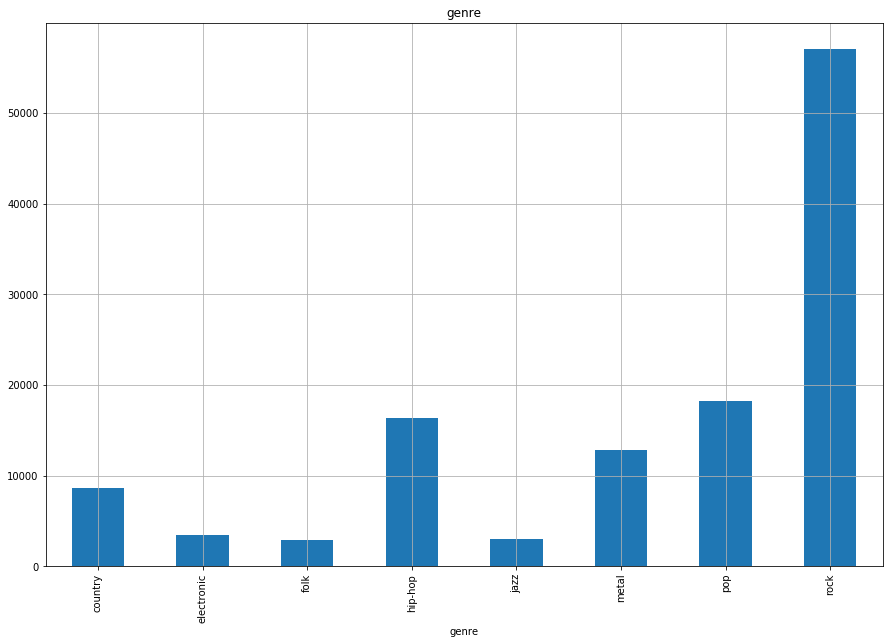

In [13]:
df_cleaned.groupby('genre')['genre'].count().plot(kind='bar', figsize=(15,10), grid=True, subplots=True)
print(df_cleaned.groupby('genre')['genre'].count())

## Feature Engineering

### Combining classes

In [164]:
df_cleaned.loc[df_cleaned['genre'] == 'r&b', 'genre'] = 'hip-hop'
df_cleaned.loc[df_cleaned['genre'] == 'indie', 'genre'] = 'folk'

### Saving the cleaned dataset to file for re-use

In [167]:
df_cleaned.to_csv('lyrics_cleaned.csv', index=None, header=True)

### Subsampling 2900 random lyrics for each genre
This sample is used for evaluating the the classifier and tuning hyper-parameters.

Since the distribution of the classes in the original dataset is highly imbalanced, we have to make sure that this fact doesn't impact model performance.

2900 because it is (almost) the maximum number of the smalest category.

In [14]:
df_sampled = df_cleaned.groupby('genre').apply(lambda genre: genre.sample(2900, replace=False, random_state=666)).reset_index(level=0, drop=True).reset_index()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018999A753C8>],
      dtype=object)

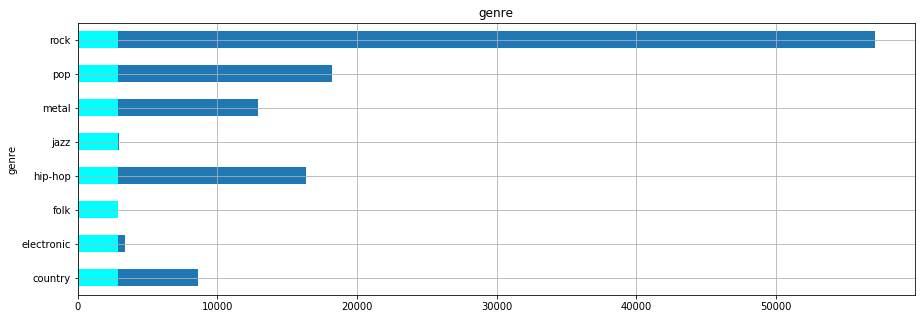

In [15]:
fig = df_cleaned.groupby('genre')['genre'].count().plot(kind='barh', figsize=(15,5), grid=True, subplots=True, stacked=True)
df_sampled.groupby('genre')['genre'].count().plot(kind='barh', figsize=(15,10), grid=True, subplots=True, ax=fig, color='cyan')

## Evaluating and fitting esteminators

### Evaluation Pipeline
Using the sub-sampled dataset to evaluate classifiers and tune hyper-parameters.

In [225]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

params_eval = {
    'clf__estimator__loss': ('log',),
    'clf__estimator__penalty': ('l2',),
    'clf__estimator__alpha': (1e-05,),
    'clf__estimator__max_iter': (1000, 2000,),
    'clf__estimator__tol': (1e-3,),
    'clf__estimator__shuffle': (True,),
    'clf__estimator__warm_start': (False,),
    'vect__max_df': (0.4, 0.6, 0.8, 1.0,),
    'vect__max_features': (2000, 2500, 3000, 4000, 5000, 6000,),
    'vect__stop_words': (stopwords.words(['english']),),
    'vect__lowercase': (True,),
    'vect__analyzer': ('word',)
}

pipeline_eval = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(SGDClassifier()))
])

X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(df_sampled['lyrics'], df_sampled['genre'], test_size=0.1, random_state=42, stratify=df_sampled['genre'])

clf_pipeline_eval = RandomizedSearchCV(pipeline, param_distributions=params_eval, pre_dispatch=4, n_jobs=-1,
                                   n_iter=20, cv=5, error_score=np.nan, refit=True, verbose=3)

clf_pipeline_eval.fit(X_train_eval, y_train_eval)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                                        

In [226]:
print('EVAL: train set: ', clf_pipeline_sgd.score(X_train_eval, y_train_eval))
print('EVAL: test set: ', clf_pipeline_sgd.score(X_test_eval, y_test_eval))

EVAL: train set:  0.7161877394636015
EVAL: test set:  0.44612068965517243


### Final Pipeline
The best parameters from the evaluation and tuning step before are used to fit the final pipeline with the full dataset.

In [231]:
params_final = clf_pipeline_eval.best_params_

pipeline_final = Pipeline([
    ('vect', TfidfVectorizer(
        max_df = params_final.get('vect__max_df'),
        max_features = params_final.get('vect__max_features'),
        stop_words = params_final.get('vect__stop_words'),
        lowercase = params_final.get('vect__lowercase'),
        analyzer = params_final.get('vect__analyzer')
    )),
    ('clf', OneVsRestClassifier(SGDClassifier(
        loss = params_final.get('clf__estimator__loss'),
        penalty = params_final.get('clf__estimator__penalty'),
        alpha = params_final.get('clf__estimator__alpha'),
        max_iter = params_final.get('clf__estimator__max_iter'),
        tol = params_final.get('clf__estimator__tol'),
        shuffle = params_final.get('clf__estimator__shuffle'),
        warm_start = params_final.get('clf__estimator__shuffle')
    )))
])

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df_cleaned['lyrics'], df_cleaned['genre'], test_size=0.1, random_state=42, stratify=df_cleaned['genre'])

pipeline_final.fit(X_train_full, y_train_full)

print(pipeline_final.score(X_train_full, y_train_full))
print(pipeline_final.score(X_test_full, y_test_full))

0.6494067665828485
0.6232843137254902


In [235]:
pipeline_final.steps[1][1].label_binarizer_.classes_

array(['country', 'electronic', 'folk', 'hip-hop', 'jazz', 'metal', 'pop',
       'rock'], dtype='<U10')

### Vizualize the TF-IDF vectors
Scatter-plotting the TF-IDF vectors of the testing-set.

Text(0, 0.5, 'PCA 1')

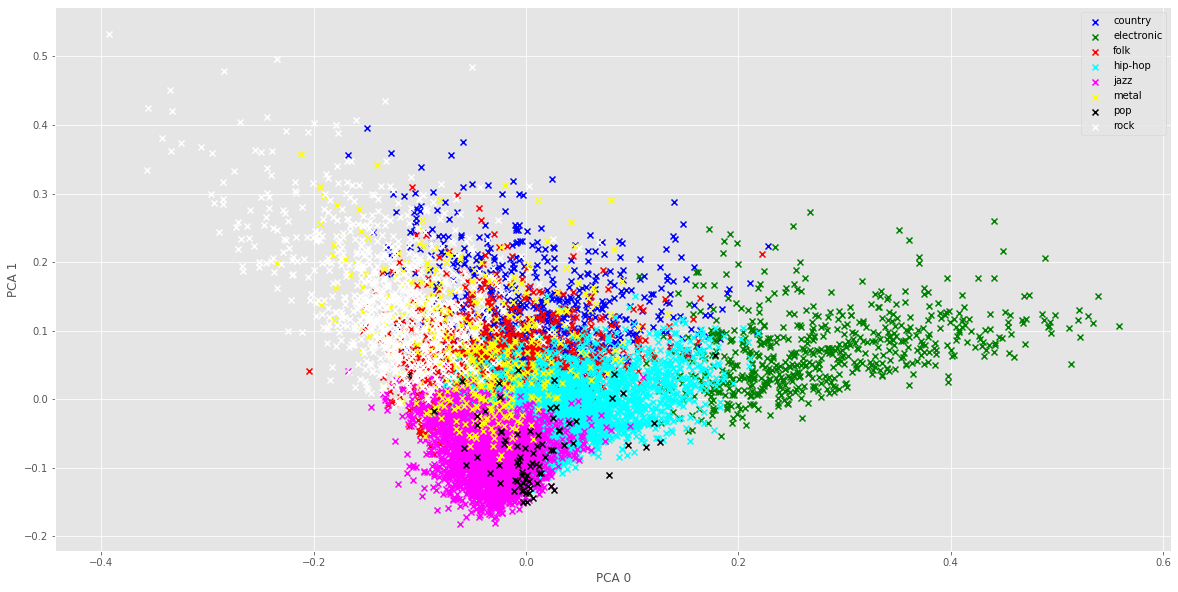

In [234]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

X = pipeline_final.steps[0][1].transform(X_test_full)

km = KMeans(
    n_clusters = 8, 
    init = 'k-means++', 
    max_iter=1000,
    n_jobs=-1)
km.fit(X)

clusters = km.predict(X)

# X_reduced = TruncatedSVD(n_components=8).fit_transform(X.todense())
# two_dim = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(X_reduced)

two_dim = PCA(n_components=2).fit_transform(X.todense())

scatter_x = two_dim[:, 0]
scatter_y = two_dim[:, 1]

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

cmap = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'cyan',
    4: 'magenta',
    5: 'yellow',
    6: 'black',
    7: 'white'
}

labels = pipeline_final.steps[1][1].label_binarizer_.classes_

# group by clusters and scatter plot every cluster
# with a colour and a label
for group, label in zip(np.unique(clusters), labels):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=label, marker="x")

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")

### Visualize the predicted labels against the true ones.

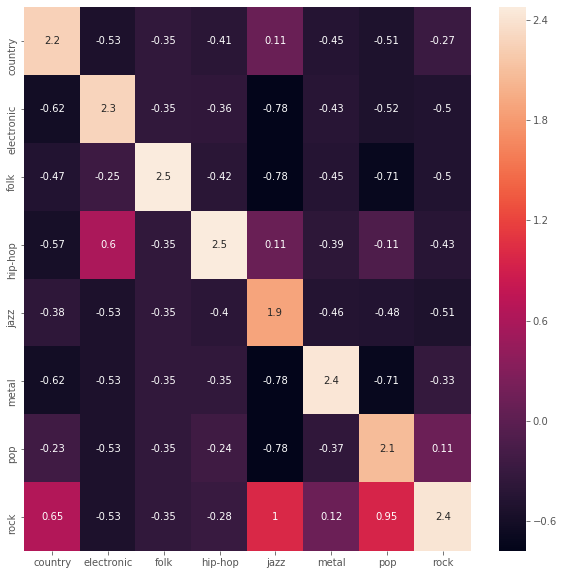

In [238]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y = pipeline_final.steps[1][1].classes_

y_pred = pipeline_final.predict(X_test_full)
y_true = y_test_full

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=y, columns=y)

# normalizing the values
df_cm = (df_cm - df_cm.mean()) / df_cm.std()

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(df_cm, annot=True, ax=ax)

## Testing the trained model with real-world data

In [22]:
lyrics = input()

lyrics = re.sub(r'[^A-Za-z]', ' ', lyrics)
# remove all single characters surrounded by whitepace
lyrics = re.sub(r'\s+[a-zA-Z]\s+', ' ', lyrics)
# remove single characters at beginning of text
lyrics = re.sub(r'\^[a-zA-Z]\s+', ' ', lyrics)
# replace repeated whitespaces with single whitespace
lyrics = re.sub(r'\s+', ' ', lyrics, flags=re.I)
# replaces repeated chars by two ('aaaaaaah' => 'aah', 'helllloooooooo' => 'helloo')
lyrics = re.sub(r'(.)\1{2,}', r'\1\1', lyrics, flags=re.I)
# converts all to lowercase
lyrics = lyrics.lower()
# lemmatizes words ('am, are, is => be', 'car, cars, car's, cars' => car')
lyrics = ' '.join([WordNetLemmatizer().lemmatize(w) for w in lyrics.split()])
# remove leading and trailing whitespaces
lyrics = lyrics.strip()

# lyrics = clf_pipeline_sgd.best_estimator_.steps[0][1].transform([lyrics])
pred = clf_pipeline_sgd.best_estimator_.predict([lyrics])
print('>>> ', pred[0])

 From the mist, a shape, a ship, is taking form And the silence of the sea is about to drift into a storm Sign of power, show of force Raise the anchor, battleship's plotting its course Pride of a nation, a beast made of steel Bismarck in motion, king of the ocean He was made to rule the waves across the seven seas To lead the war machine To rule the waves and lead the Kriegsmarine The terror of the seas The Bismarck and the Kriegsmarine Two thousand men, and fifty thousand tons of steel Set the course for the Atlantic with the Allies on their heel Firepower, firefight Battle Stations, keep the targets steady in sight Into formation, the hunt has begun Death and damnation, the fleet is coming He was made to rule the waves across the seven seas



>>>  metal


## Saving the classifier
Since the classifier is actualy a pipeline (TFIDFVectorizer -> OneVsRestClassifier -> SGDClassifier), we only need one export. We also export it directly into the folder of our backend-service so it will be copyed to the docker container when build. This also makes updating the container easier when the model gets updated.

**Note:** the OneVsRestClassifier also has an embeded LabelBinarizer to one-hot encode the class labels.

In [233]:
import joblib
from pathlib import Path

target_dir = 'backend'
target_file = 'clf_pipeline_sgd'
target_suffix = '.joblib'
path = Path(target_dir, target_file).with_suffix(target_suffix)

joblib.dump(pipeline_final, path)

['backend\\clf_pipeline_sgd.joblib']